In [ ]:
#for evaluate

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# cd [your src path]
%cd /content/drive/MyDrive/bistelligence/BISTelligence/src

/content/drive/MyDrive/bistelligence/BISTelligence/src


In [ ]:
%pip install pyod tensorflow shap

In [4]:
from sklearn.utils.validation import check_is_fitted
import scipy.stats as ss
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import joblib
import shap
from tensorflow.keras.models import load_model
import pandas as pd

     
import data.preprocessing as dp
import model.models as mm
import XAI.xai as xx

In [5]:
path = '/content/drive/MyDrive/bistelligence/BIS_data/BISTelligen_Project_Data.csv'
train_data, test_data = 0, 0
threshold = 0

trainer = mm.ModelTrain()

In [6]:
def SetData(scaled=True, key_num = -1):
  global train_data, test_data

  train_data, test_data = dp.GetPreprocessedData(path, scaled, key_num = key_num)

In [7]:
def GetModel(model_name='MCD', param_dict={}):
  '''
  input
  - model_name
  - param_dict
  model parameter
  [default value in 'ModelTrain' Class]
  param_dict = {'contamination': 0.01,
                           'nu': 0.01,
                           'novelty': True,
                           'random_state': 42,
                           'n_components': 1,
                           'covariance_type': 'full',
                           'momentum': 0.9,
                           'learning_rate': 0.03,
                           'epochs': 100,
                           'patience': 10,
                           'n_neighbors': 20,
                           'kernel': 'rbf',
                           'degree': 3,
                           'n_estimators': 100,
                           'support_fraction': None}
  ------------------------------------------------------
  return
  - model
  '''

  global trainer

  trainer.SetTrainer(train_data)
  trainer.SetParam(param_dict)
  model = trainer.GetTrainedModel(model_name)

  return model

In [8]:
def GetAnomalyScore(model=None):
  '''
  input
  - model
  ---------------------
  return
  - anomaly score
  '''

  
  model_name = type(model).__name__
  if model_name == 'GaussianMixture':
    model_name = 'GMM'


  if model_name in ['MCD','LOF']:
    anomaly_score = model.decision_function(test_data)

  elif model_name in ['OCSVM','IForest']:
    anomaly_score = model.decision_function(test_data) + np.abs(np.min(model.decision_function(test_data)))
  elif model_name == 'GMM':
    anomaly_score = np.sum(-model._estimate_weighted_log_prob(test_data), axis = 1)
  else:
    reconstruction = model.predict(test_data)
    anomaly_score = np.mean(np.power(test_data-reconstruction,2),axis=1)
    

  return anomaly_score

In [9]:
def ShowHealthIndex(model = None, anomaly_score = None, scaled = True, key_num = 123456):
  '''
  input
  - model

  - anomaly_score

  - scaled
  True = RobustScaling, False = No scaling

  - key_num
  select key in 0~6

  -----------------------
  return
  - visualize anomaly score by scatterplot
  '''

  model_name = type(model).__name__
  if model_name == 'Sequential':
    model_name = 'AutoEncoder'
  elif model_name == 'GaussianMixture':
    model_name = 'GMM'
  sns.scatterplot(range(len(anomaly_score)), anomaly_score)
  plt.title('{} health index in key {} '.format(model_name, key_num ,scaled), fontsize = 25)

In [50]:
def DoXAI(model = None, threshold = 0, plot_type = 0, sample_index = 0):
 '''
  input
  - model

  - threshold

  - plot_type (0 or 1)
  0 = summary plot(bar type), 1 = force plot
 
  - sample_index
  sample index number
  --------------------------------------------
  return
  - XAI result visualizaion
  '''

  model_name = type(model).__name__
  if model_name == 'GaussianMixture':
    model_name = 'GMM'

  # AutoEncoder
  if model_name == 'Sequential':
    model_name = 'AutoEncoder'
    score = GetAnomalyScore(model)
    exp_model= xx.AutoEncoderSHAP(threshold_to_explain=threshold, reconstruction_error_percent=0.9 ,shap_values_selection = 'constant')
    shap_values_all = exp_model.explain_unsupervised_data(x_train=train_data, 
                                                                   x_explain=test_data,
                                                                   autoencoder=model,
                                                                   return_shap_values=True)
    
    print(shap_values_all)

    if plot_type == 0:    
      col = shap_values_all.sum().sort_values().index[0]
      shap_values_all.drop([col], axis=1, inplace = True)  
      shap.summary_plot(shap_values_all.values, shap_values_all.columns, plot_type = "bar", show=False)
      plt.title('{} summary_plot about {} in key{}'.format(model_name, col ,i), fontsize = 20)


    elif plot_type == 1:
      shap_values = shap_values_all.iloc[sample_index]
      col = shap_values[shap_values == -1].index
      shap_values.drop(col, inplace = True)
      print(shap_values.index)
      reconstruction = pd.DataFrame(model.predict(train_data),columns = train_data.columns)

      # mse 가장 큰(shap value 정확하지 않은) 변수 제거 후 expected value 계산
      train_data.drop(col, axis=1, inplace = True)
      reconstruction.drop(col, axis=1, inplace = True)
      error = np.mean(np.power(train_data-reconstruction,2),axis=1)
      expected_value = np.mean(error)

      shap.force_plot(expected_value, shap_values = shap_values.values,feature_names = shap_values.index,show = False,  matplotlib = True)
      plt.title('{} force_plot about {} in key{}'.format(model_name, col[0], i), fontsize = 20)

    plt.gcf().subplots_adjust(bottom=0.2)
    plt.savefig('XAI/plot/{}_key{}_type{}.png'.format(model_name, i, plot_type), bbox_inches = 'tight', pad_inches=0.1)
    plt.show()

  # Other Models
  else:
    score = GetAnomalyScore(model)
    shap_values_all, explainer = xx.OtherModelSHAP(model).novelty_contribution(train_data, test_data, score, threshold)
    if plot_type == 0:
      shap.summary_plot(shap_values_all.values, shap_values_all.columns, plot_type = "bar", show=False)
      plt.title('{} summary_plot in key{}'.format(model_name, i), fontsize = 20)
    elif plot_type == 1:
      shap.force_plot(explainer.expected_value, shap_values = shap_values_all.values[0],feature_names = shap_values_all.columns,show = False,  matplotlib = True)
      plt.title('{} force_plot in key{}'.format(model_name, i), fontsize = 20)
    plt.gcf().subplots_adjust(bottom=0.2)
    plt.savefig('XAI/plot/{}_key{}_type{}.png'.format(model_name, i, plot_type), bbox_inches = 'tight', pad_inches=0.1)
    plt.show()
     

In [24]:
save_path = '/content/drive/MyDrive/bistelligence/BISTelligence/src/model/saved_model'
best_path = '/content/drive/MyDrive/bistelligence/BISTelligence/src/model/best_model'

In [25]:
# model.saved_model 폴더에 모델 저장
def SaveModel(model, path ,key_num = 0):
  model_name = type(model).__name__
  if model_name == 'GaussianMixture':
    model_name = 'GMM'

  #AutoEncoder
  if model_name =='Sequential':
    file = 'AE_key' + str(key_num) + '.h5'
    filename = '/'.join([path, file])
    model.save(filename)
    print('model saved in PATH : {}'.format(filename))

  #Other Models
  else:
    file = model_name + '_key' +str(key_num)
    filename = '/'.join([path, file])
    #'_'.join(['best', type(model).__name__])
    joblib.dump(model, filename)
    print('model saved in PATH : {}'.format(filename))

In [26]:
# model.saved_model 폴더에서 모델 불러옴
def LoadModel(model_name, path ,key_num = 0):
  
  #AutoEncoder
  if model_name =='AE':
    file = 'AE_key' + str(key_num) + '.h5'
    filename = '/'.join([path, file])
    model = load_model(filename)
    print('model load from PATH : {}'.format(filename))

  #Other Models
  else:
    file = model_name + '_key' +str(key_num)
    filename = '/'.join([path, file])
    model = joblib.load(filename)
    print('model load from PATH : {}'.format(filename))
    
  return model

In [14]:
SetData()

# MCD 

model saved in PATH : /content/drive/MyDrive/bistelligence/BISTelligence/src/model/saved_model/MCD_key1
model saved in PATH : /content/drive/MyDrive/bistelligence/BISTelligence/src/model/saved_model/MCD_key2
model saved in PATH : /content/drive/MyDrive/bistelligence/BISTelligence/src/model/saved_model/MCD_key3
model saved in PATH : /content/drive/MyDrive/bistelligence/BISTelligence/src/model/saved_model/MCD_key4
model saved in PATH : /content/drive/MyDrive/bistelligence/BISTelligence/src/model/saved_model/MCD_key5
model saved in PATH : /content/drive/MyDrive/bistelligence/BISTelligence/src/model/saved_model/MCD_key6


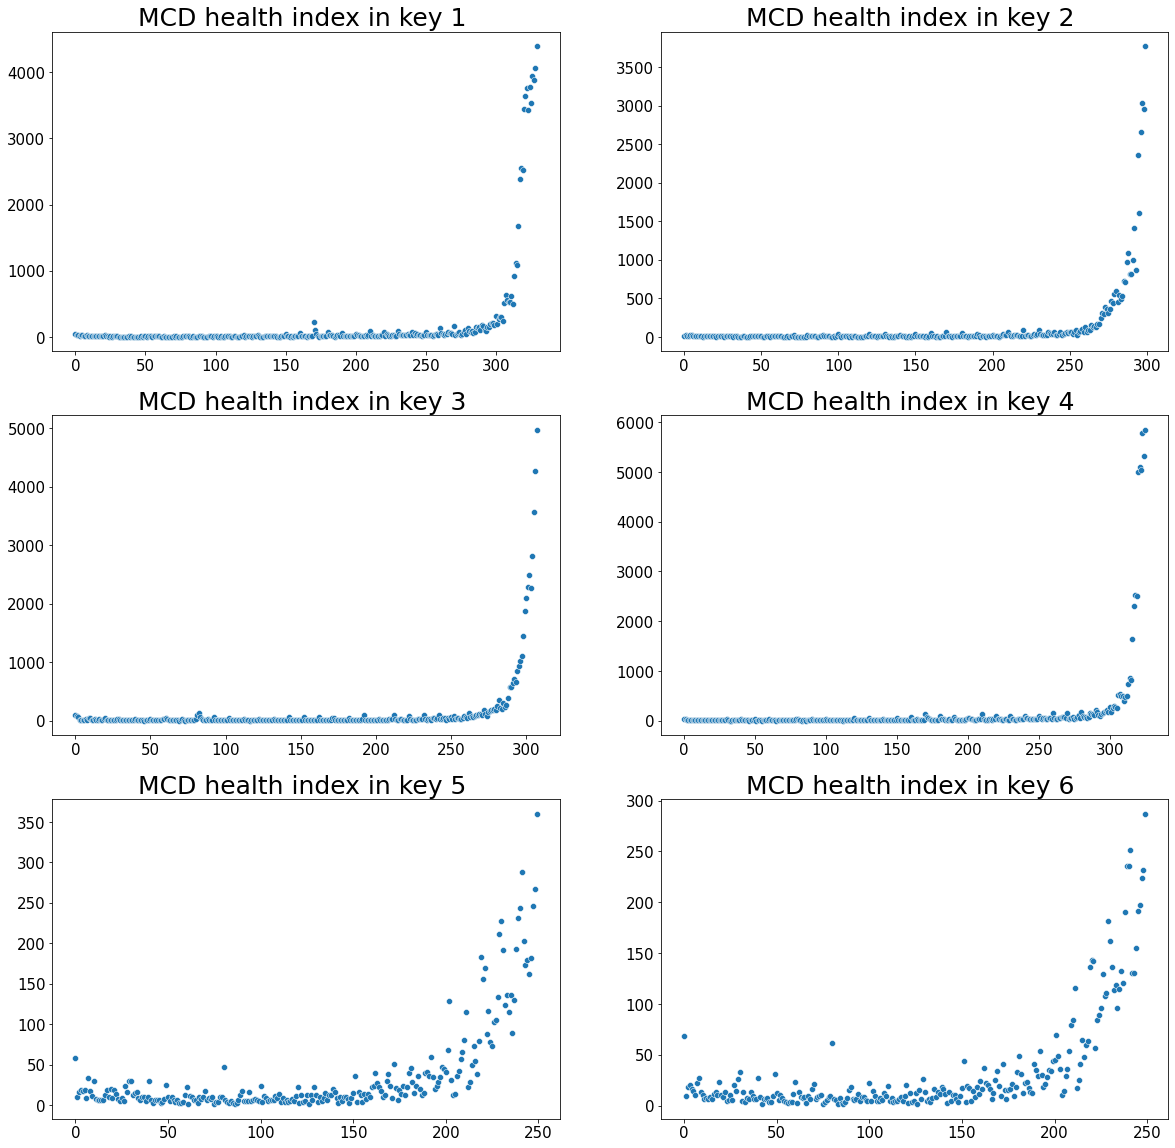

In [39]:
# scale o
plt.rcParams["figure.figsize"] = (20, 20)
for i in range(1, 7):
    plt.subplot(3,2,i)
    SetData(key_num = i)
    model = GetModel(model_name = 'MCD')
    model_name = type(model).__name__
    SaveModel(model,path = save_path, key_num = i)
    score = GetAnomalyScore(model)
    ShowHealthIndex(model, score, key_num = i)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

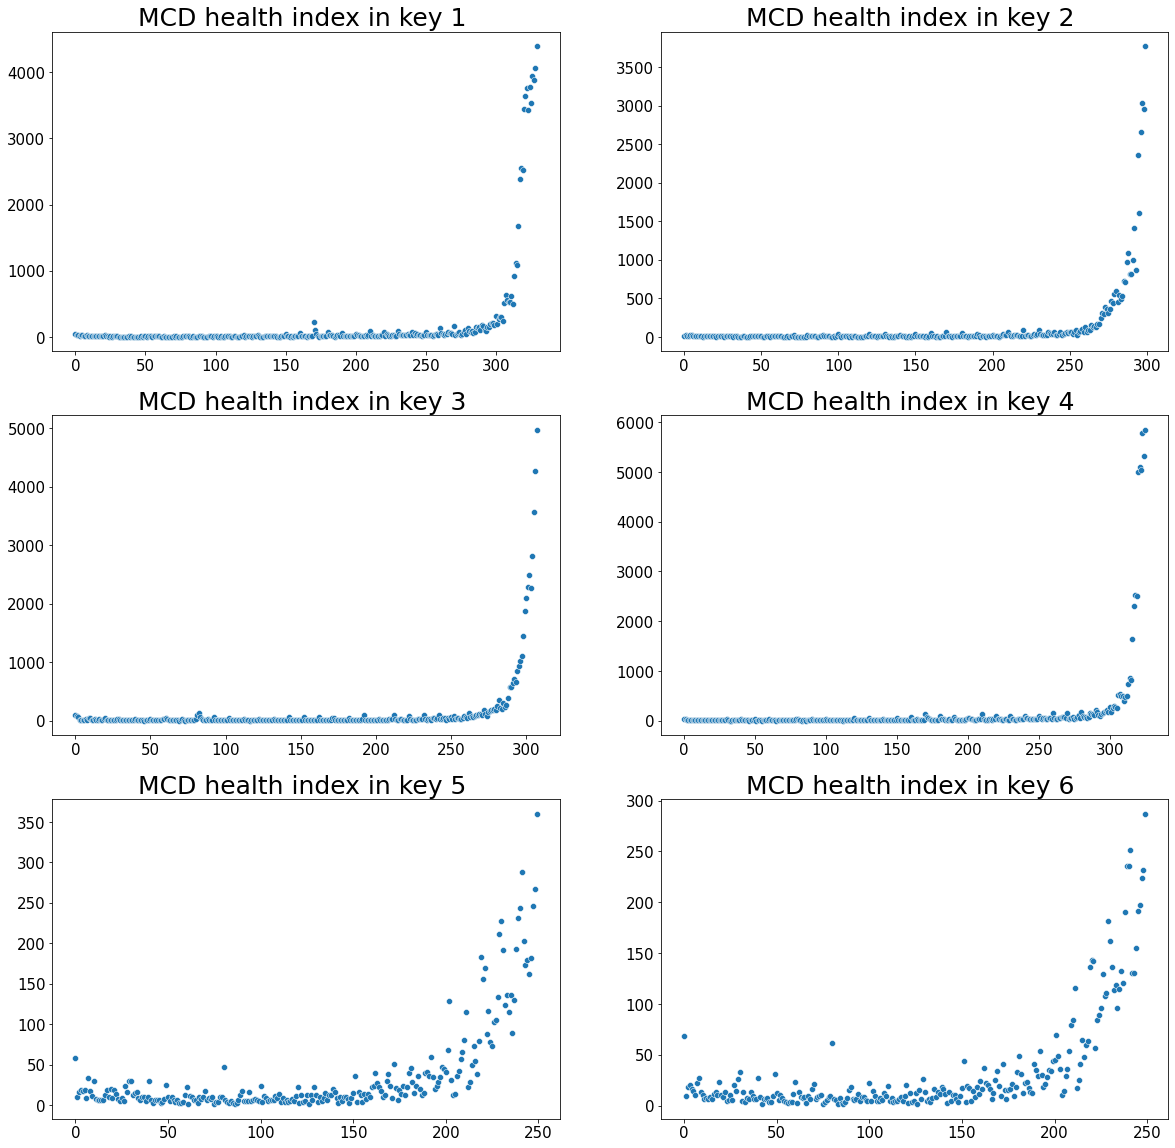

In [28]:
# scale X
plt.rcParams["figure.figsize"] = (20, 20)
for i in range(1, 7):
    plt.subplot(3,2,i)
    SetData(scaled = False, key_num = i)
    model = GetModel(model_name = 'MCD')
    model_name = type(model).__name__
    score = GetAnomalyScore(model)
    ShowHealthIndex(model, score, key_num = i)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

# LOF

model saved in PATH : /content/drive/MyDrive/bistelligence/BISTelligence/src/model/saved_model/LOF_key1
model saved in PATH : /content/drive/MyDrive/bistelligence/BISTelligence/src/model/saved_model/LOF_key2
model saved in PATH : /content/drive/MyDrive/bistelligence/BISTelligence/src/model/saved_model/LOF_key3
model saved in PATH : /content/drive/MyDrive/bistelligence/BISTelligence/src/model/saved_model/LOF_key4
model saved in PATH : /content/drive/MyDrive/bistelligence/BISTelligence/src/model/saved_model/LOF_key5
model saved in PATH : /content/drive/MyDrive/bistelligence/BISTelligence/src/model/saved_model/LOF_key6
LOF(algorithm='auto', contamination=0.01, leaf_size=30, metric='minkowski',
  metric_params=None, n_jobs=1, n_neighbors=400, novelty=True, p=2)


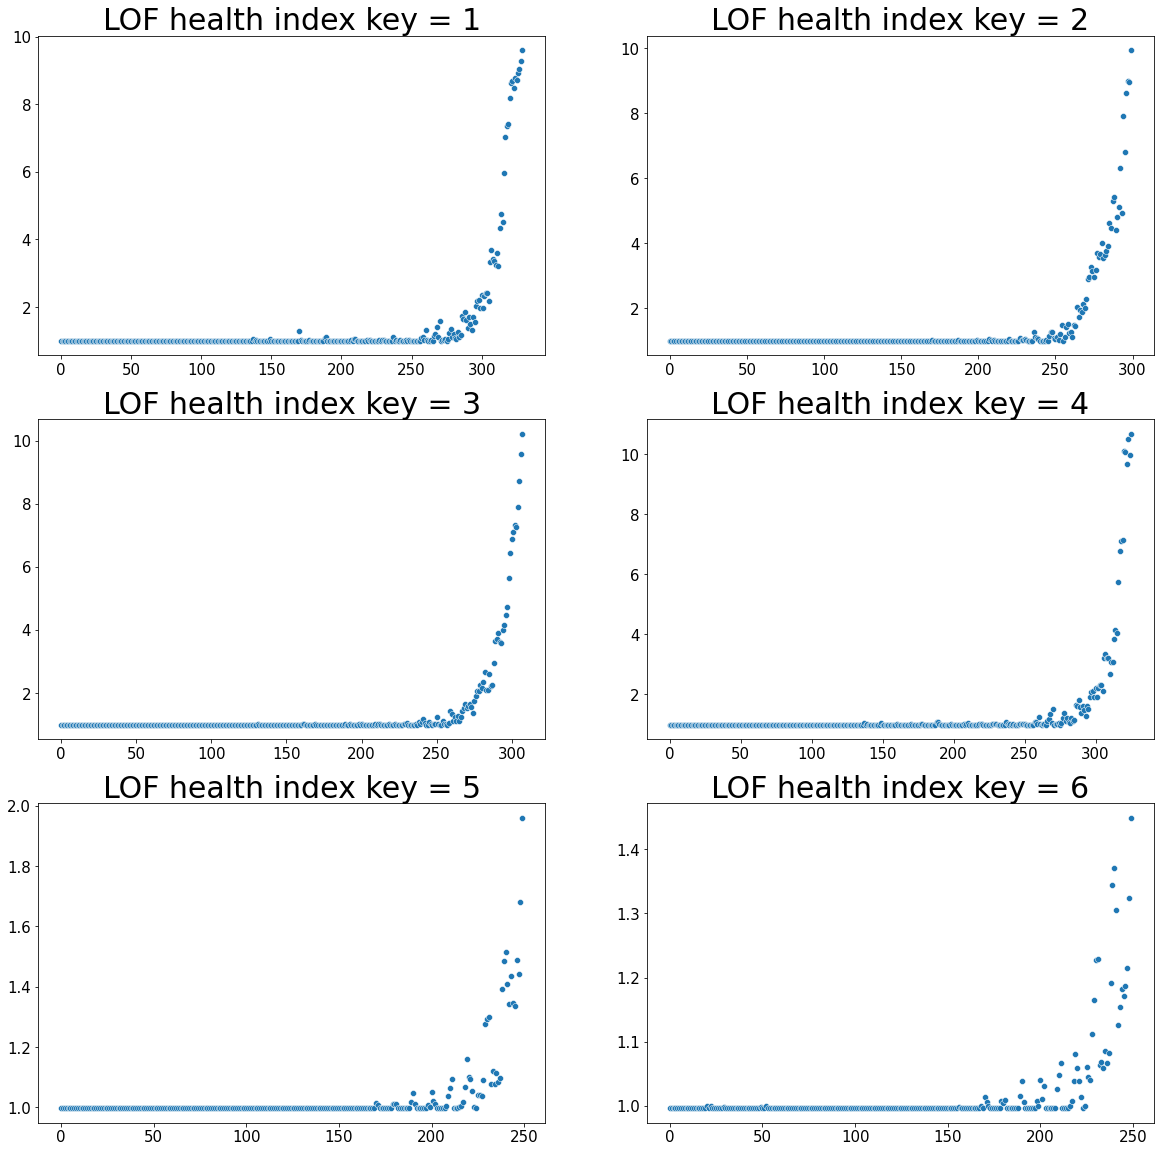

In [40]:
# scale o
plt.rcParams["figure.figsize"] = (20, 20)
for i in range(1, 7):
    plt.subplot(3,2,i)
    SetData(key_num = i)
    model = GetModel(model_name = 'LOF',param_dict = {'n_neighbors':400})
    model_name = type(model).__name__
    SaveModel(model,path = save_path, key_num = i)
    score = GetAnomalyScore(model)
    ShowHealthIndex(model, score, key_num = i)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.title('{} health index key = {}'.format(model_name, i),fontsize=30)
print(model)

LOF(algorithm='auto', contamination=0.01, leaf_size=30, metric='minkowski',
  metric_params=None, n_jobs=1, n_neighbors=30, novelty=True, p=2)


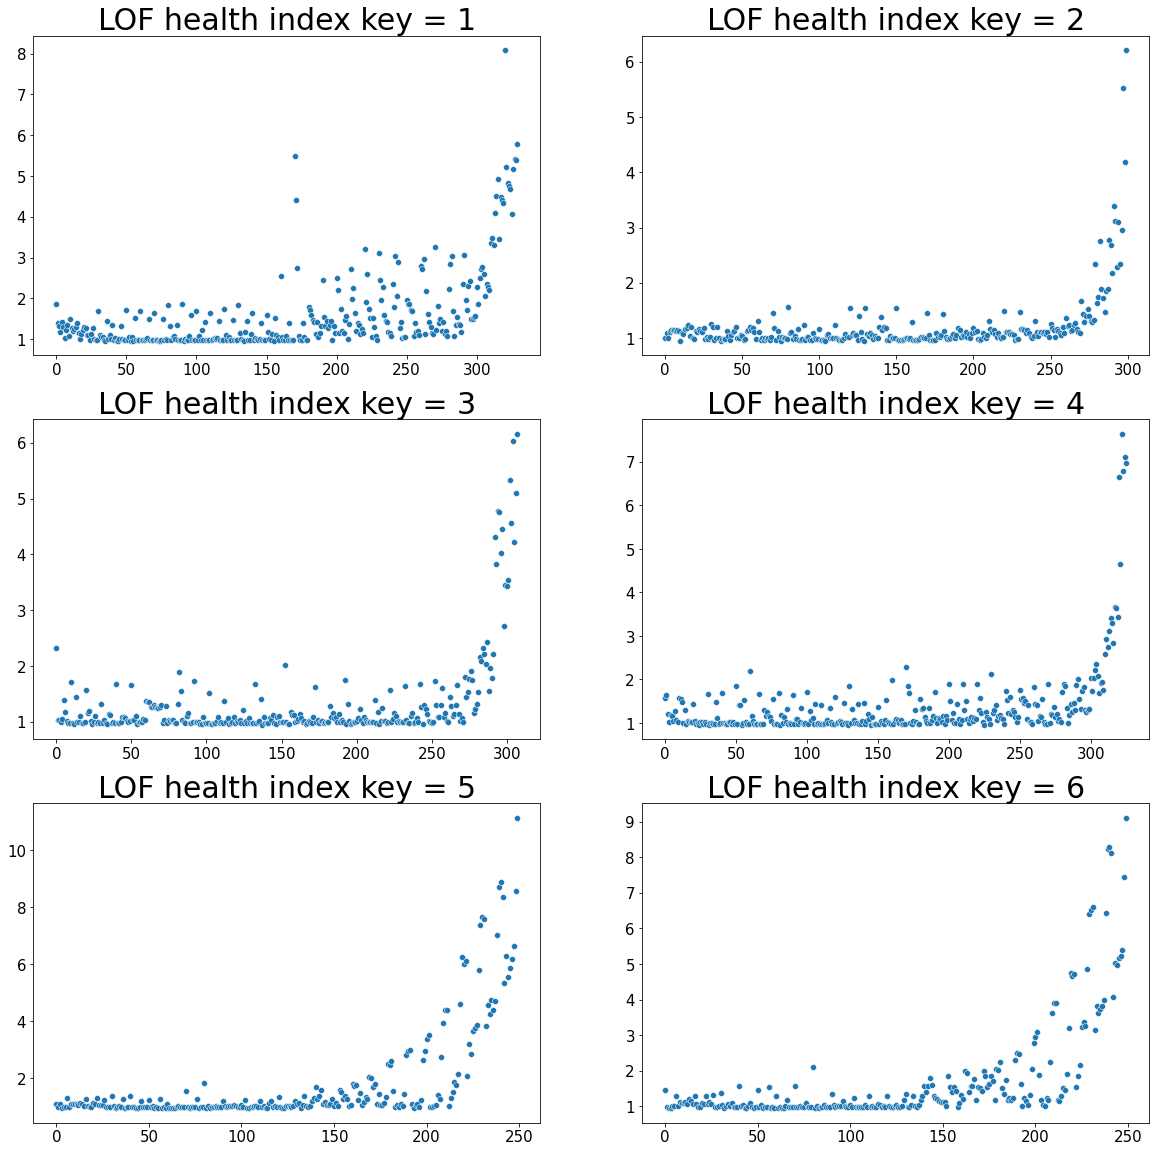

In [31]:
# scale x
plt.rcParams["figure.figsize"] = (20, 20)
for i in range(1, 7):
    plt.subplot(3,2,i)
    SetData(scaled = False, key_num = i)
    model = GetModel(model_name = 'LOF', param_dict = {'n_neighbors': 30})
    model_name = type(model).__name__
    score = GetAnomalyScore(model)
    ShowHealthIndex(model, score, key_num = i)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.title('{} health index key = {}'.format(model_name, i),fontsize=30)
print(model)

# OCSVM

model saved in PATH : /content/drive/MyDrive/bistelligence/BISTelligence/src/model/saved_model/OCSVM_key1
model saved in PATH : /content/drive/MyDrive/bistelligence/BISTelligence/src/model/saved_model/OCSVM_key2
model saved in PATH : /content/drive/MyDrive/bistelligence/BISTelligence/src/model/saved_model/OCSVM_key3
model saved in PATH : /content/drive/MyDrive/bistelligence/BISTelligence/src/model/saved_model/OCSVM_key4
model saved in PATH : /content/drive/MyDrive/bistelligence/BISTelligence/src/model/saved_model/OCSVM_key5
model saved in PATH : /content/drive/MyDrive/bistelligence/BISTelligence/src/model/saved_model/OCSVM_key6
OCSVM(cache_size=200, coef0=0.0, contamination=0.01, degree=3, gamma='auto',
   kernel='rbf', max_iter=-1, nu=0.01, shrinking=True, tol=0.001,
   verbose=False)


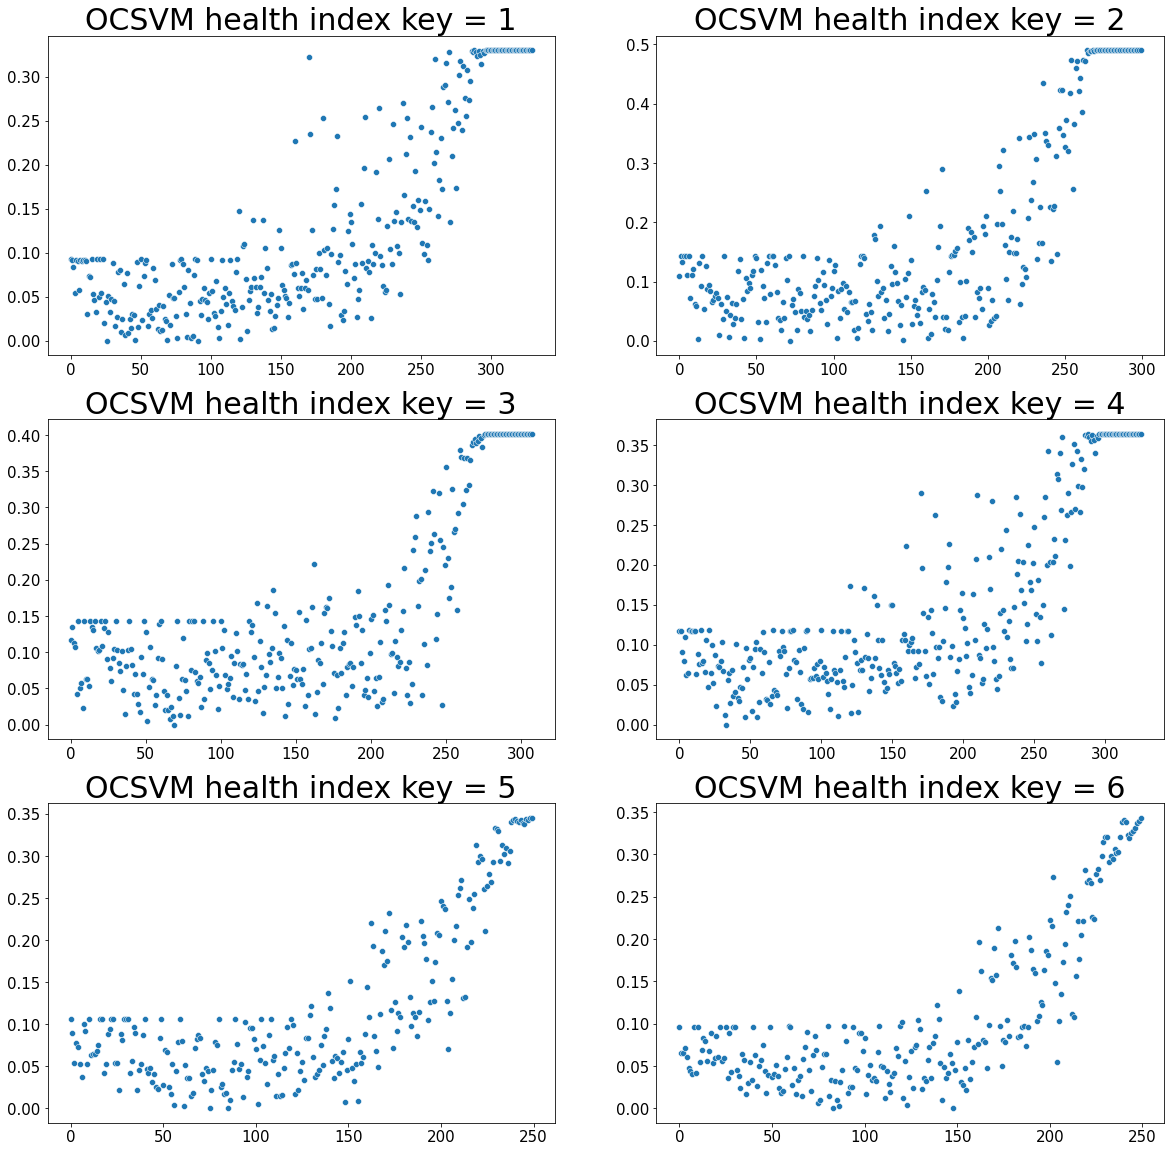

In [41]:
# scale o
plt.rcParams["figure.figsize"] = (20, 20)
for i in range(1, 7):
    plt.subplot(3,2,i)
    SetData(key_num = i)
    model = GetModel(model_name = 'OCSVM')
    model_name = type(model).__name__
    SaveModel(model,path = save_path, key_num = i)
    score = GetAnomalyScore(model)
    ShowHealthIndex(model, score, key_num = i)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.title('{} health index key = {}'.format(model_name, i),fontsize=30)
print(model)

OCSVM(cache_size=200, coef0=0.0, contamination=0.01, degree=3, gamma='auto',
   kernel='rbf', max_iter=-1, nu=0.01, shrinking=True, tol=0.001,
   verbose=False)


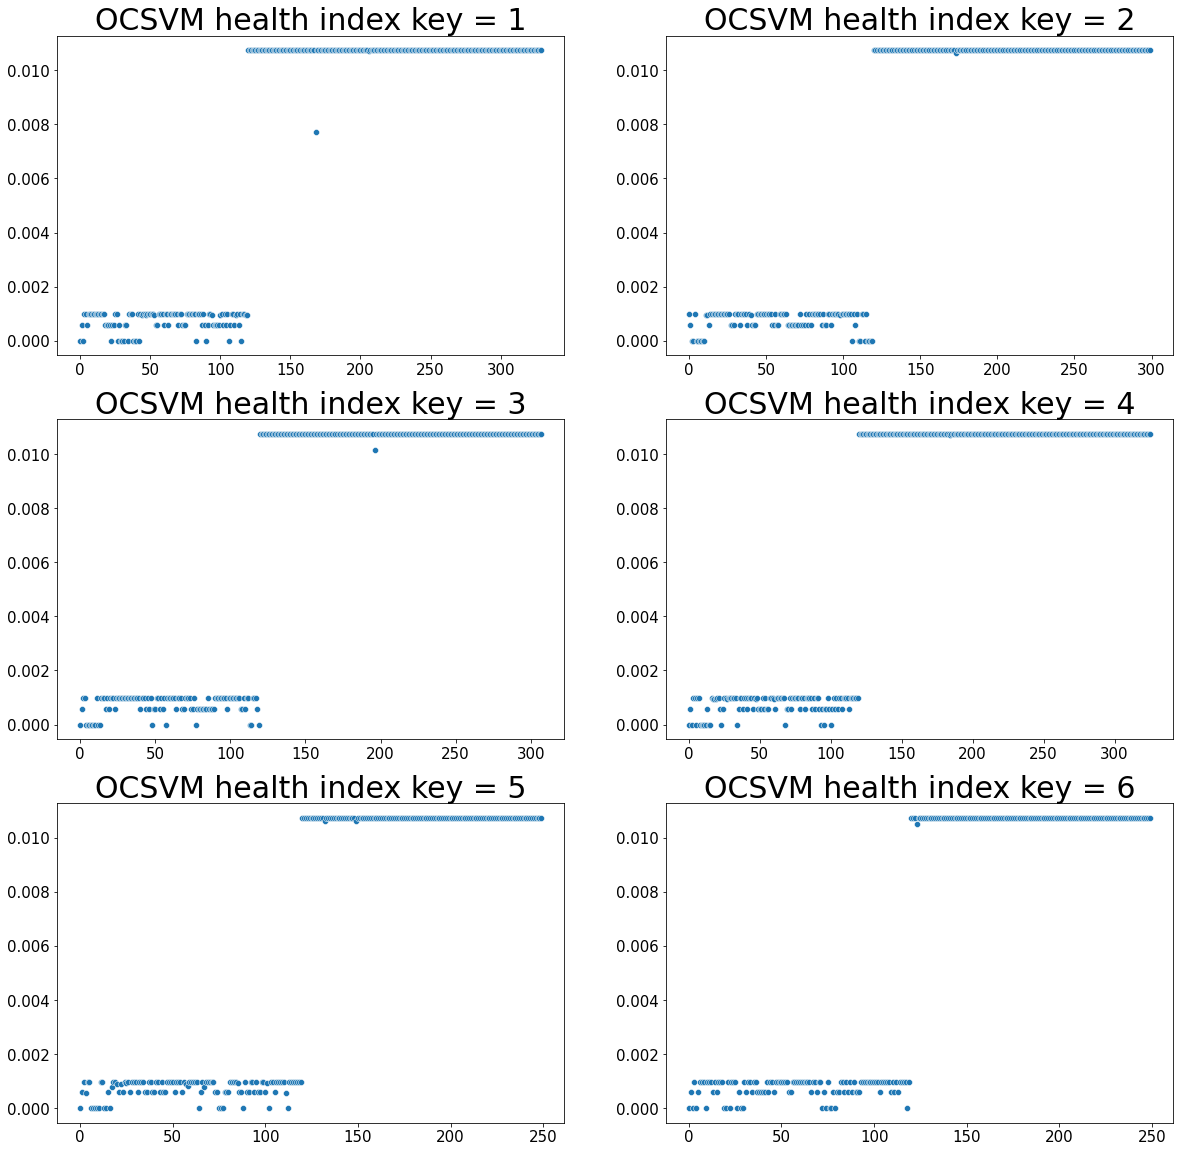

In [33]:
# scale x
plt.rcParams["figure.figsize"] = (20, 20)
for i in range(1, 7):
    plt.subplot(3,2,i)
    SetData(scaled = False, key_num = i)
    model = GetModel(model_name = 'OCSVM')
    model_name = type(model).__name__
    score = GetAnomalyScore(model)
    ShowHealthIndex(model, score, key_num = i)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.title('{} health index key = {}'.format(model_name, i),fontsize=30)
print(model)

# GMM

model saved in PATH : /content/drive/MyDrive/bistelligence/BISTelligence/src/model/saved_model/GMM_key1
14.092801887991795
model saved in PATH : /content/drive/MyDrive/bistelligence/BISTelligence/src/model/saved_model/GMM_key2
13.41972035591151
model saved in PATH : /content/drive/MyDrive/bistelligence/BISTelligence/src/model/saved_model/GMM_key3
8.448546548107952
model saved in PATH : /content/drive/MyDrive/bistelligence/BISTelligence/src/model/saved_model/GMM_key4
13.349549639602376
model saved in PATH : /content/drive/MyDrive/bistelligence/BISTelligence/src/model/saved_model/GMM_key5
13.112070299500715
model saved in PATH : /content/drive/MyDrive/bistelligence/BISTelligence/src/model/saved_model/GMM_key6
13.55887505842536
GaussianMixture(n_components=2)


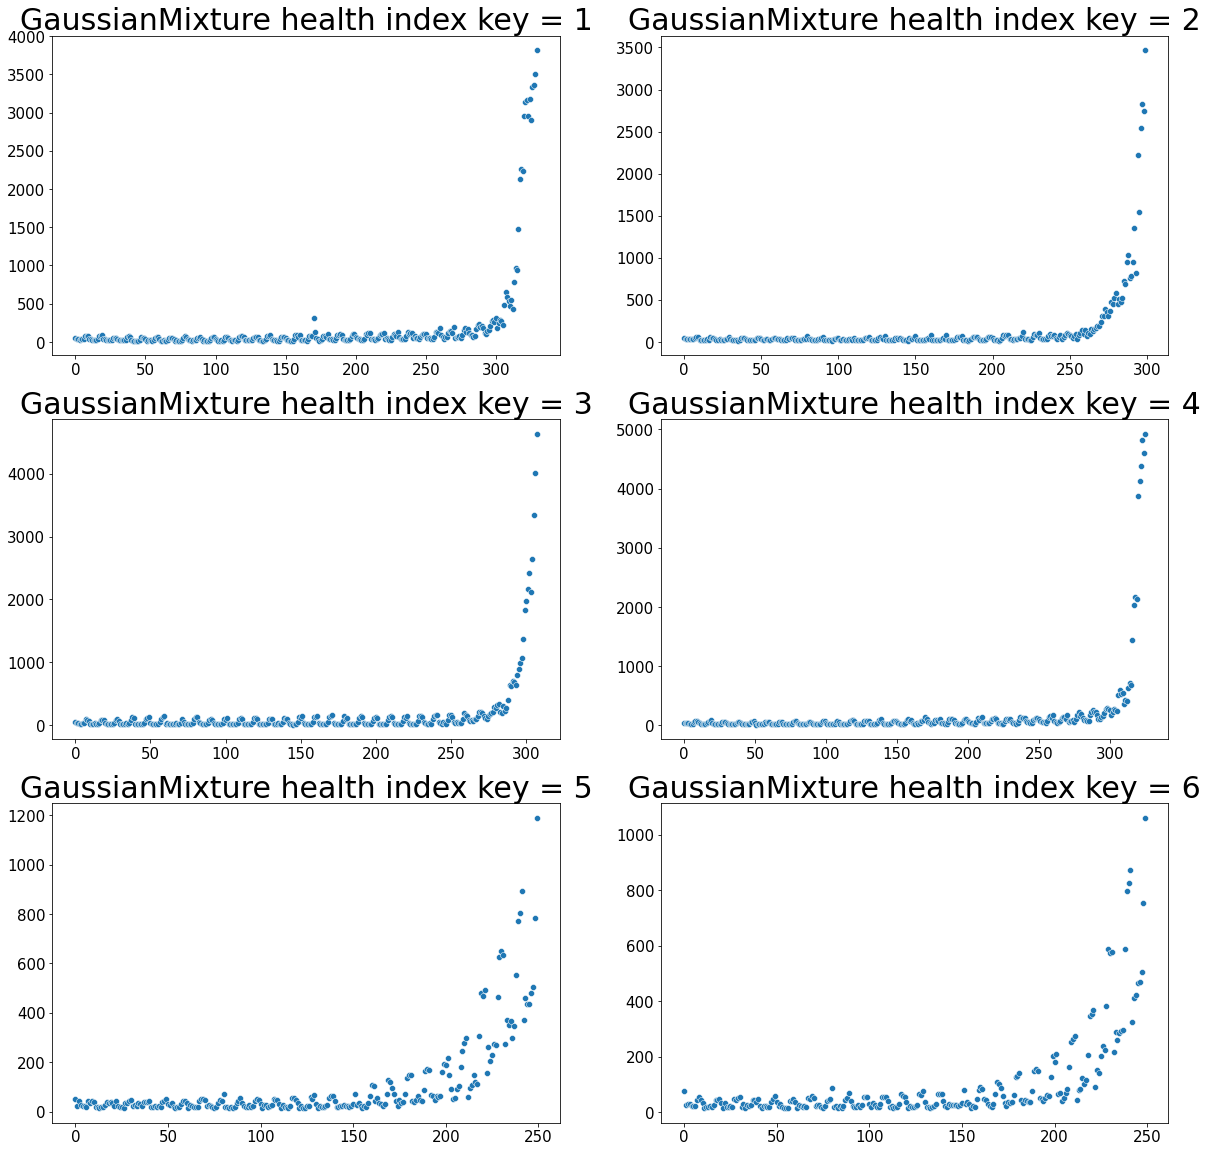

In [42]:
# scale o
plt.rcParams["figure.figsize"] = (20, 20)
for i in range(1, 7):
    plt.subplot(3,2,i)
    SetData(key_num = i)
    model = GetModel(model_name = 'GMM', param_dict = {'n_components': 2, 'covariance_type': 'full'})
    model_name = type(model).__name__
    SaveModel(model,path = save_path, key_num = i)
    score = GetAnomalyScore(model)
    print(np.min(score))
    ShowHealthIndex(model, score, key_num = i)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.title('{} health index key = {}'.format(model_name, i),fontsize=30)
print(model)

GaussianMixture(n_components=2)


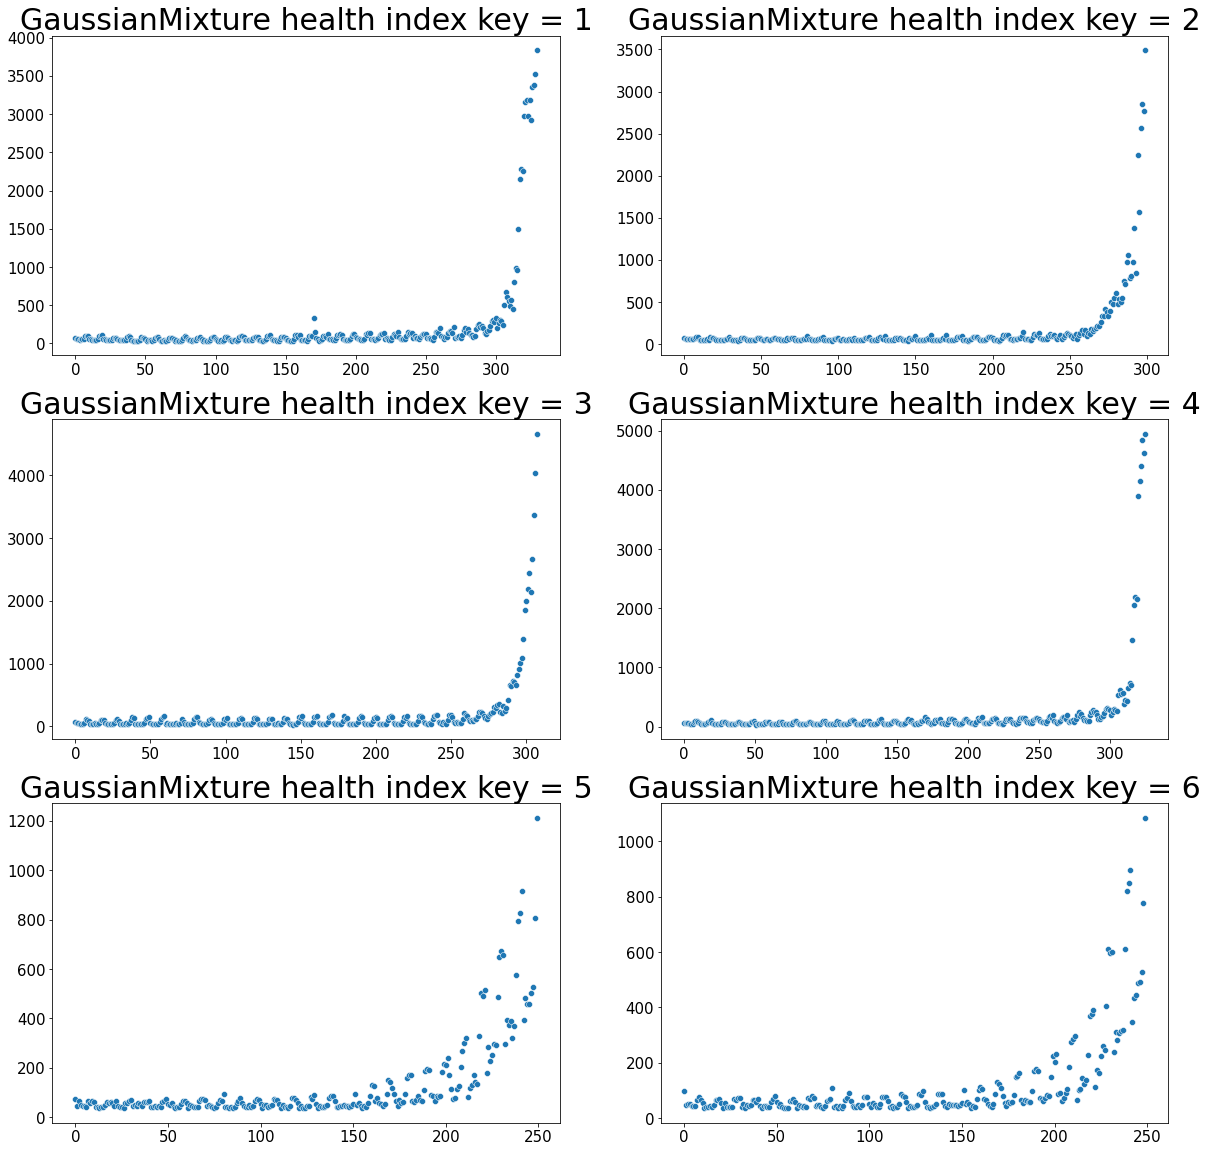

In [35]:
# scale x
plt.rcParams["figure.figsize"] = (20, 20)
for i in range(1, 7):
    plt.subplot(3,2,i)
    SetData(scaled = False, key_num = i)
    model = GetModel(model_name = 'GMM', param_dict = {'n_components':2, 'covariance_type': 'full'})
    model_name = type(model).__name__
    score = GetAnomalyScore(model)
    ShowHealthIndex(model, score, key_num = i)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.title('{} health index key = {}'.format(model_name, i),fontsize=30)
print(model)

# Isolation Forest

model saved in PATH : /content/drive/MyDrive/bistelligence/BISTelligence/src/model/saved_model/IForest_key1
model saved in PATH : /content/drive/MyDrive/bistelligence/BISTelligence/src/model/saved_model/IForest_key2
model saved in PATH : /content/drive/MyDrive/bistelligence/BISTelligence/src/model/saved_model/IForest_key3
model saved in PATH : /content/drive/MyDrive/bistelligence/BISTelligence/src/model/saved_model/IForest_key4
model saved in PATH : /content/drive/MyDrive/bistelligence/BISTelligence/src/model/saved_model/IForest_key5
model saved in PATH : /content/drive/MyDrive/bistelligence/BISTelligence/src/model/saved_model/IForest_key6
IForest(behaviour='old', bootstrap=False, contamination=0.01,
    max_features=1.0, max_samples='auto', n_estimators=200, n_jobs=1,
    random_state=None, verbose=0)


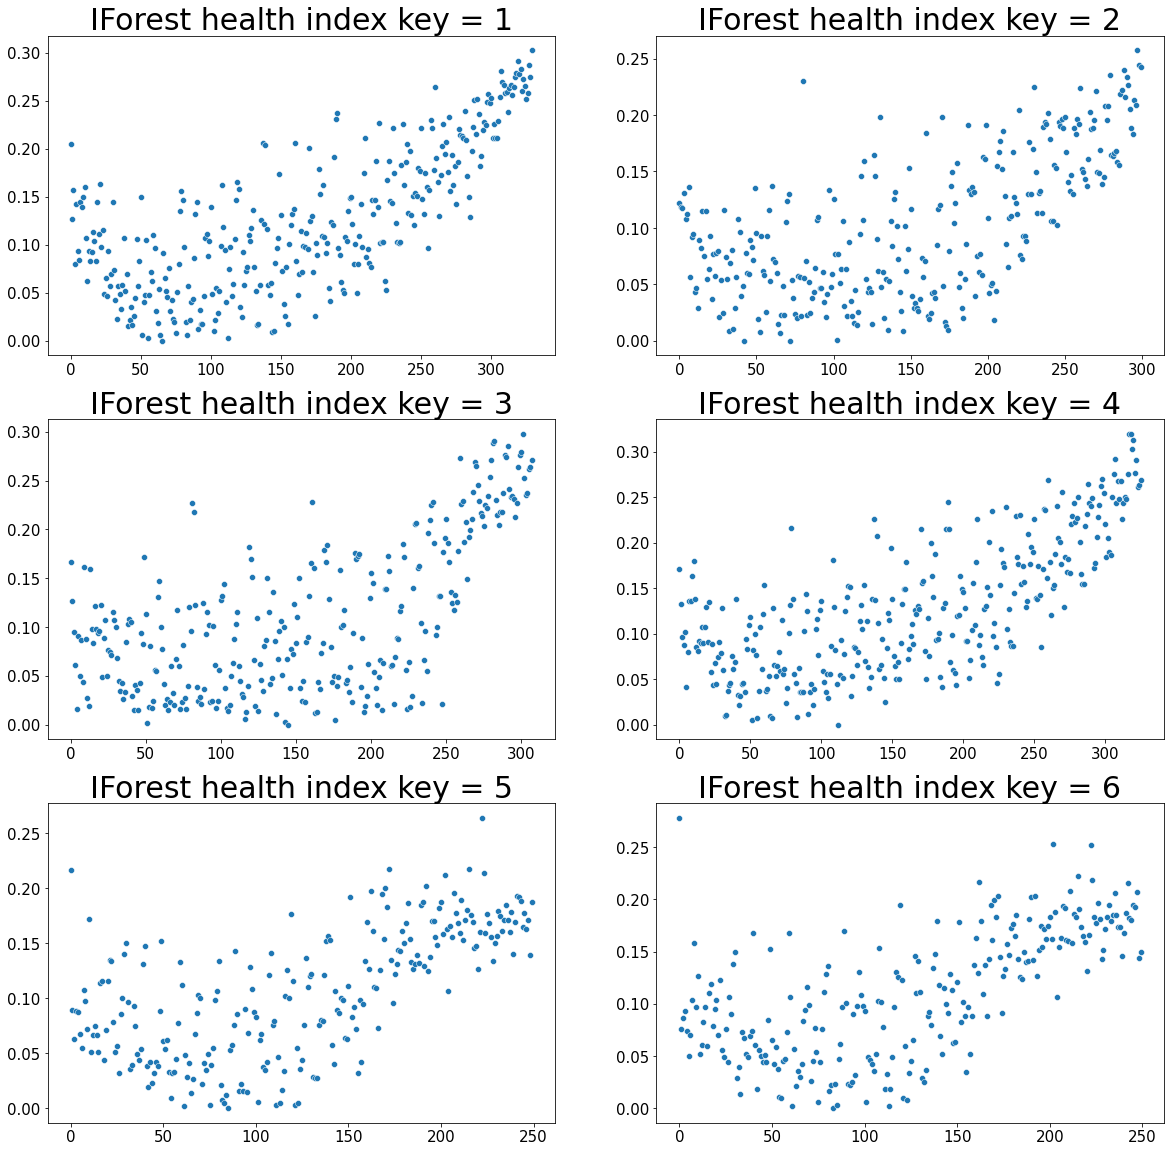

In [43]:
# scale o
plt.rcParams["figure.figsize"] = (20, 20)
for i in range(1, 7):
    plt.subplot(3,2,i)
    SetData(key_num = i)
    model = GetModel(model_name = 'IForest', param_dict = {'n_estimators': 200})
    model_name = type(model).__name__
    SaveModel(model,path = save_path, key_num = i)
    score = GetAnomalyScore(model)
    ShowHealthIndex(model, score, key_num = i)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.title('{} health index key = {}'.format(model_name, i),fontsize=30)
print(model)

IForest(behaviour='old', bootstrap=False, contamination=0.01,
    max_features=1.0, max_samples='auto', n_estimators=200, n_jobs=1,
    random_state=None, verbose=0)


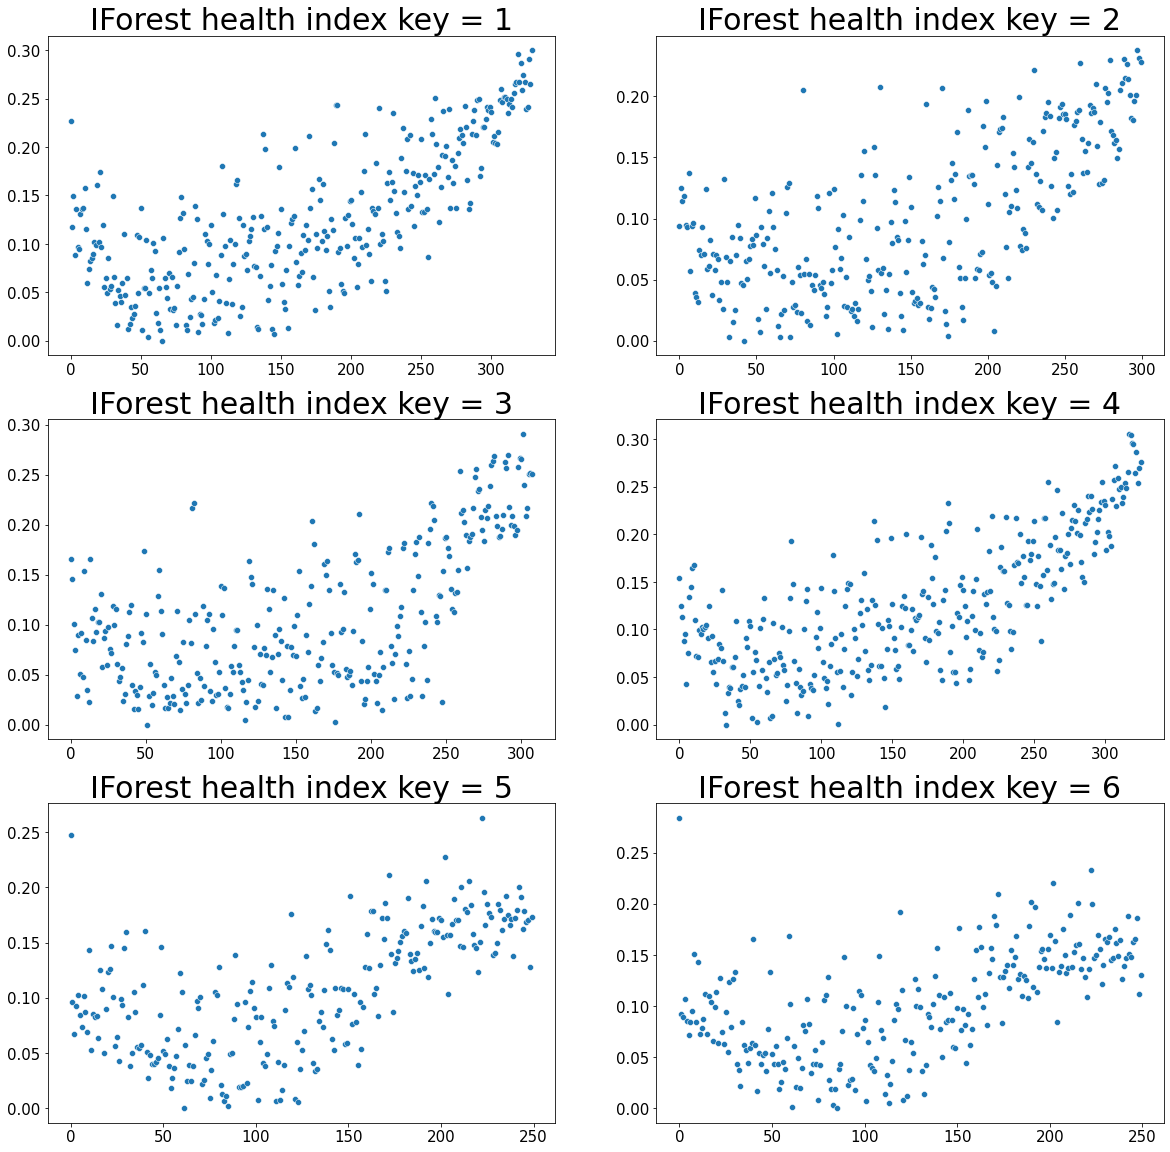

In [37]:
# scale x
plt.rcParams["figure.figsize"] = (20, 20)
for i in range(1, 7):
    plt.subplot(3,2,i)
    SetData(scaled = False, key_num = i)
    model = GetModel(model_name = 'IForest', param_dict = {'n_estimators': 200})
    model_name = type(model).__name__
    score = GetAnomalyScore(model)
    ShowHealthIndex(model, score, key_num = i)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.title('{} health index key = {}'.format(model_name, i),fontsize=30)
print(model)

# AutoEncoder

model saved in PATH : /content/drive/MyDrive/bistelligence/BISTelligence/src/model/saved_model/AE_key1.h5
11/11 [==============================] - 0s 2ms/step
model saved in PATH : /content/drive/MyDrive/bistelligence/BISTelligence/src/model/saved_model/AE_key2.h5
10/10 [==============================] - 0s 2ms/step
Epoch 141: early stopping
model saved in PATH : /content/drive/MyDrive/bistelligence/BISTelligence/src/model/saved_model/AE_key3.h5
10/10 [==============================] - 0s 3ms/step
model saved in PATH : /content/drive/MyDrive/bistelligence/BISTelligence/src/model/saved_model/AE_key4.h5
11/11 [==============================] - 0s 2ms/step
Epoch 164: early stopping
model saved in PATH : /content/drive/MyDrive/bistelligence/BISTelligence/src/model/saved_model/AE_key5.h5
8/8 [==============================] - 0s 2ms/step
Epoch 106: early stopping
model saved in PATH : /content/drive/MyDrive/bistelligence/BISTelligence/src/model/saved_model/AE_key6.h5
8/8 [==================

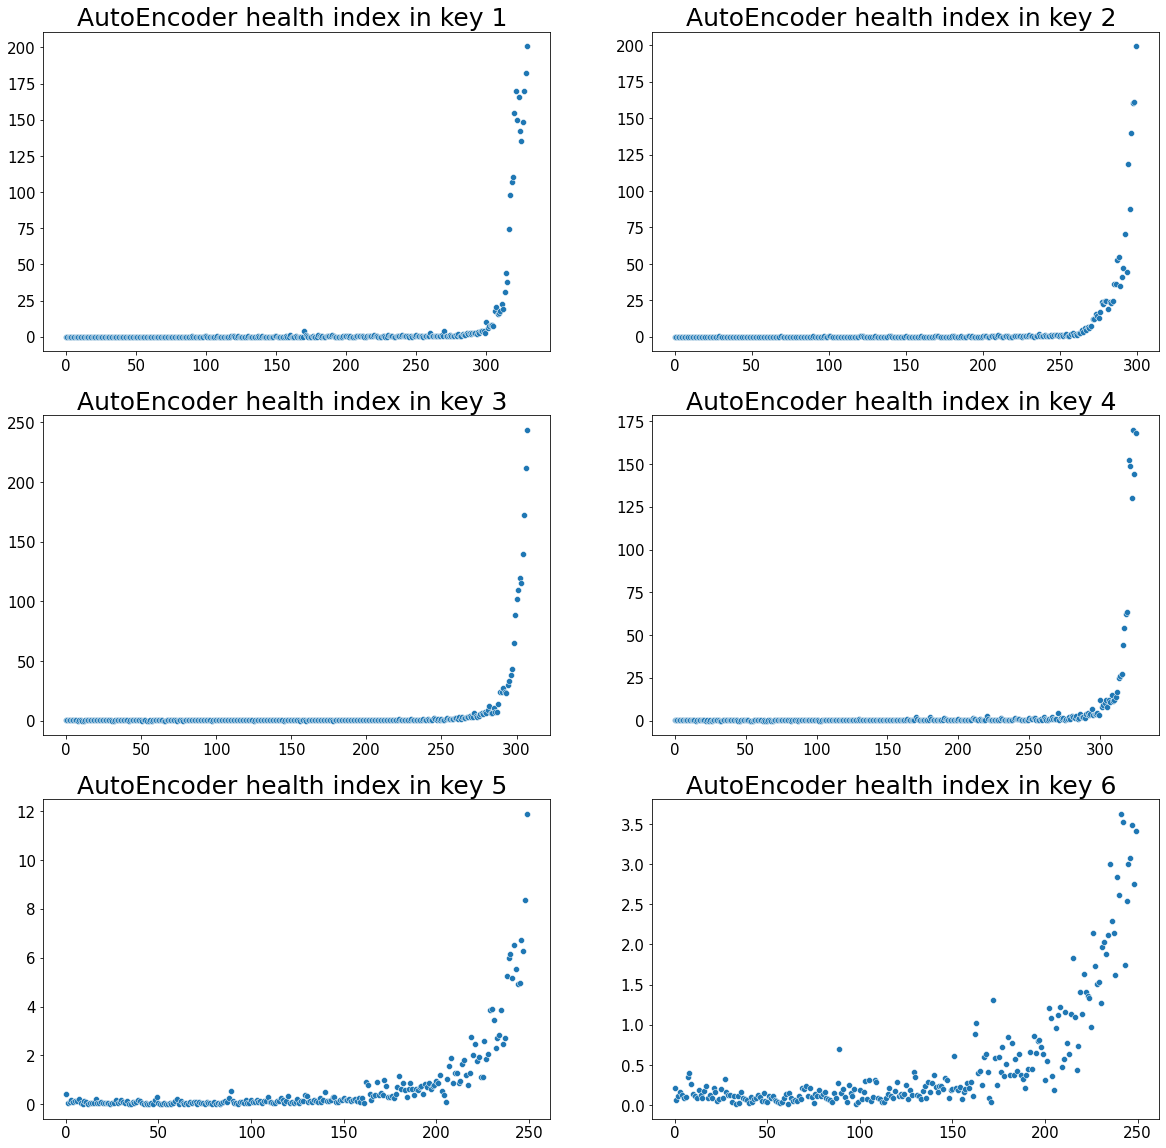

In [44]:
# scale o
plt.rcParams["figure.figsize"] = (20, 20)
for i in range(1, 7):
    plt.subplot(3,2,i)
    SetData(key_num = i)
    model = GetModel(model_name = 'AE', param_dict = {'momentum':0.6, 'learning_rate':0.03, 'patience':50,'epochs':200})
    SaveModel(model,path = save_path, key_num = i)
    model_name = type(model).__name__
    score = GetAnomalyScore(model)
    ShowHealthIndex(model, score, key_num = i)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
print(model)

Epoch 24: early stopping
11/11 [==============================] - 0s 2ms/step
Epoch 22: early stopping
10/10 [==============================] - 0s 2ms/step
Epoch 26: early stopping
10/10 [==============================] - 0s 2ms/step
Epoch 23: early stopping
11/11 [==============================] - 0s 2ms/step
Epoch 23: early stopping
8/8 [==============================] - 0s 2ms/step
Epoch 23: early stopping
8/8 [==============================] - 0s 3ms/step


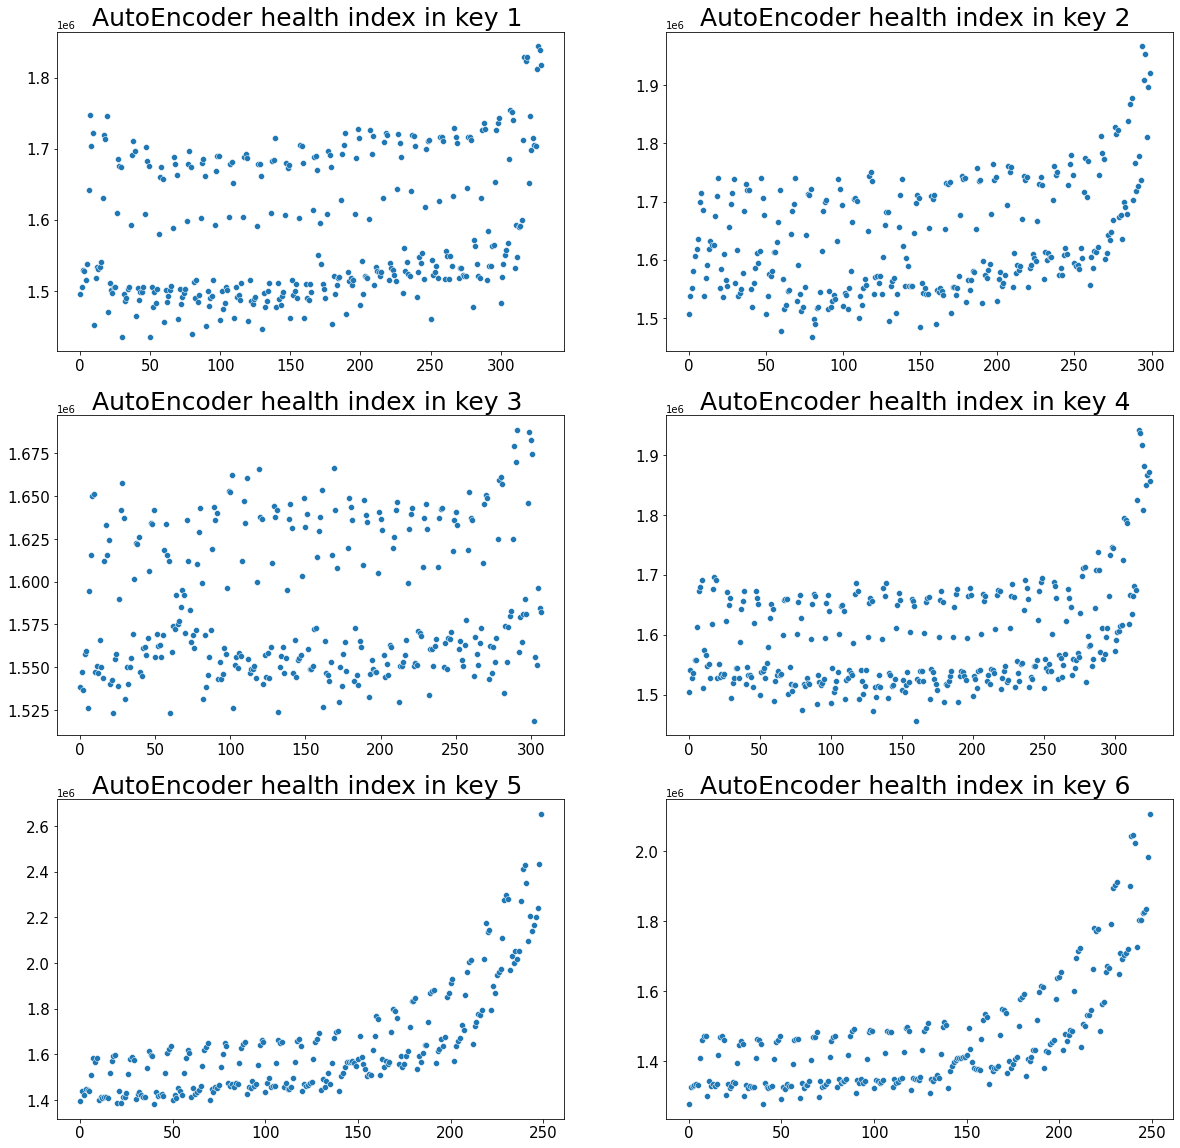

In [ ]:
# scale x
plt.rcParams["figure.figsize"] = (20, 20)
for i in range(1, 7):
    plt.subplot(3,2,i)
    SetData(scaled = False, key_num = i)
    model = GetModel(model_name = 'AE', param_dict = {'momentum': 0.6, 'learning_rate': 0.03,'patience':20})
    model_name = type(model).__name__
    score = GetAnomalyScore(model)
    ShowHealthIndex(model, score, key_num = i)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
print(model)

#Best Model XAI

model load from PATH : /content/drive/MyDrive/bistelligence/BISTelligence/src/model/saved_model/LOF_key1
model saved in PATH : /content/drive/MyDrive/bistelligence/BISTelligence/src/model/best_model/LOF_key1


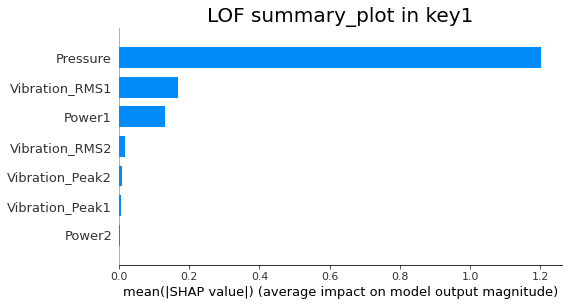

model load from PATH : /content/drive/MyDrive/bistelligence/BISTelligence/src/model/saved_model/LOF_key2
model saved in PATH : /content/drive/MyDrive/bistelligence/BISTelligence/src/model/best_model/LOF_key2


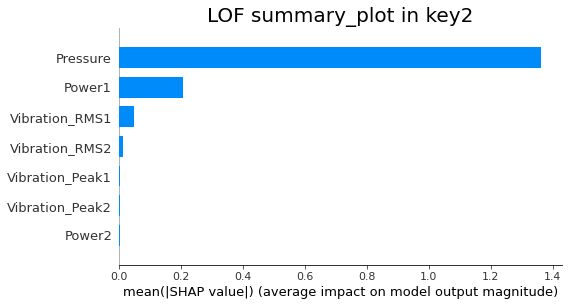

model load from PATH : /content/drive/MyDrive/bistelligence/BISTelligence/src/model/saved_model/LOF_key3
model saved in PATH : /content/drive/MyDrive/bistelligence/BISTelligence/src/model/best_model/LOF_key3


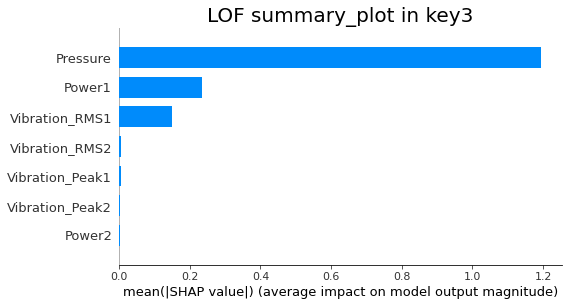

model load from PATH : /content/drive/MyDrive/bistelligence/BISTelligence/src/model/saved_model/LOF_key4
model saved in PATH : /content/drive/MyDrive/bistelligence/BISTelligence/src/model/best_model/LOF_key4


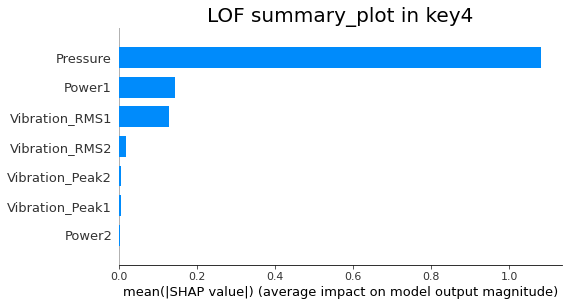

model load from PATH : /content/drive/MyDrive/bistelligence/BISTelligence/src/model/saved_model/LOF_key5
model saved in PATH : /content/drive/MyDrive/bistelligence/BISTelligence/src/model/best_model/LOF_key5


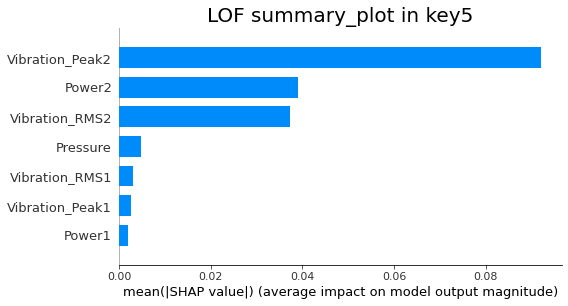

model load from PATH : /content/drive/MyDrive/bistelligence/BISTelligence/src/model/saved_model/LOF_key6
model saved in PATH : /content/drive/MyDrive/bistelligence/BISTelligence/src/model/best_model/LOF_key6


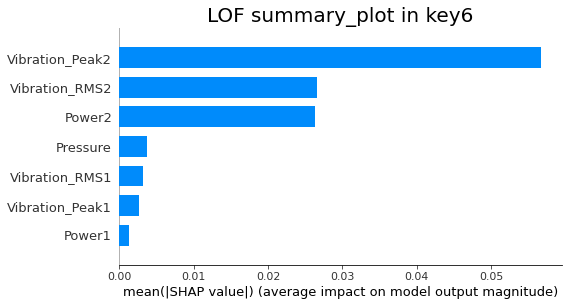

In [46]:
for i in range(1, 7):
  SetData(key_num = i)
  model = LoadModel('LOF',save_path, key_num = i)
  SaveModel(model, best_path, key_num = i)
  DoXAI(model=model, threshold = 1, plot_type = 0)

model load from PATH : /content/drive/MyDrive/bistelligence/BISTelligence/src/model/saved_model/LOF_key1
model saved in PATH : /content/drive/MyDrive/bistelligence/BISTelligence/src/model/best_model/LOF_key1


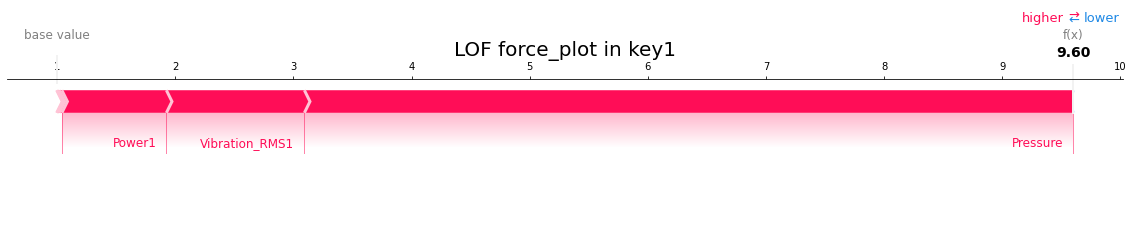

model load from PATH : /content/drive/MyDrive/bistelligence/BISTelligence/src/model/saved_model/LOF_key2
model saved in PATH : /content/drive/MyDrive/bistelligence/BISTelligence/src/model/best_model/LOF_key2


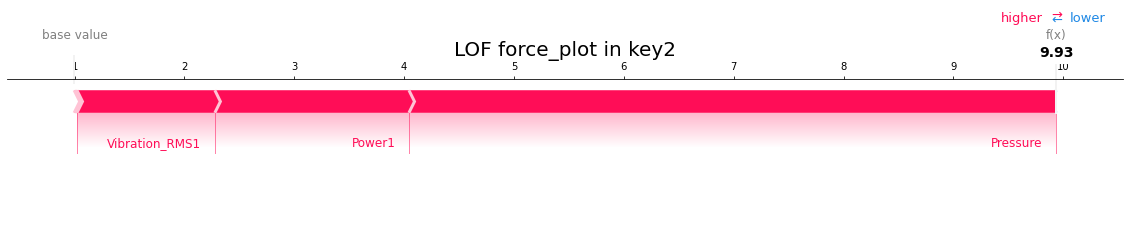

model load from PATH : /content/drive/MyDrive/bistelligence/BISTelligence/src/model/saved_model/LOF_key3
model saved in PATH : /content/drive/MyDrive/bistelligence/BISTelligence/src/model/best_model/LOF_key3


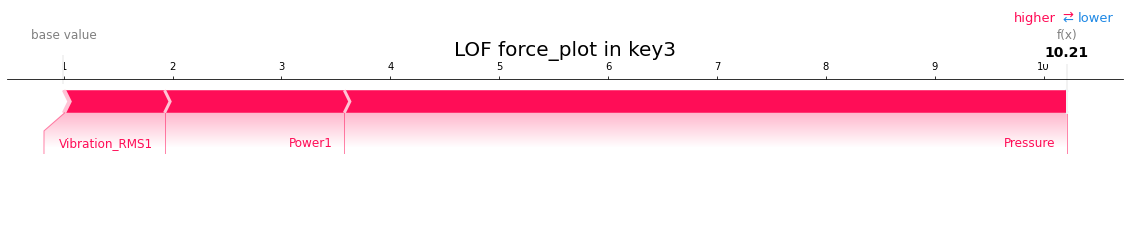

model load from PATH : /content/drive/MyDrive/bistelligence/BISTelligence/src/model/saved_model/LOF_key4
model saved in PATH : /content/drive/MyDrive/bistelligence/BISTelligence/src/model/best_model/LOF_key4


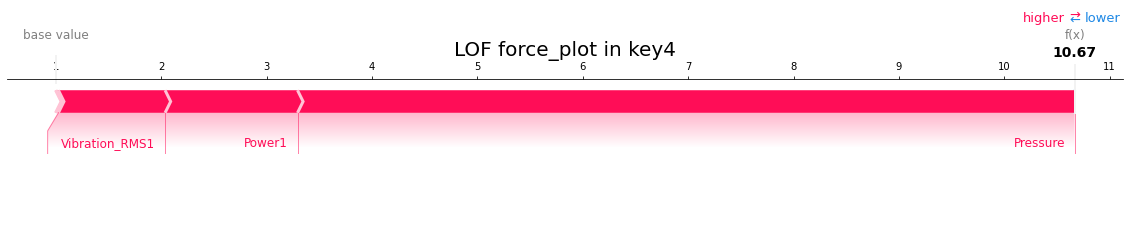

model load from PATH : /content/drive/MyDrive/bistelligence/BISTelligence/src/model/saved_model/LOF_key5
model saved in PATH : /content/drive/MyDrive/bistelligence/BISTelligence/src/model/best_model/LOF_key5


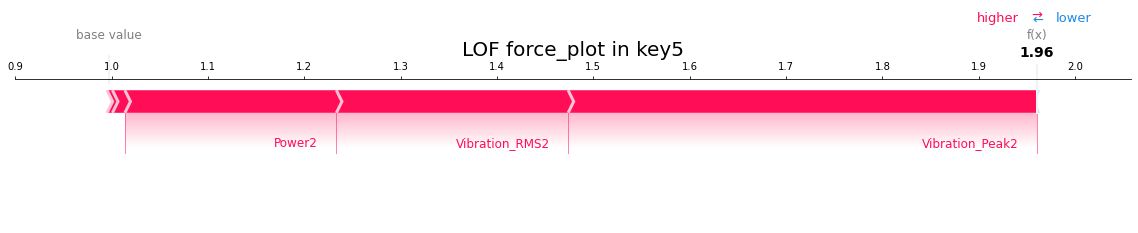

model load from PATH : /content/drive/MyDrive/bistelligence/BISTelligence/src/model/saved_model/LOF_key6
model saved in PATH : /content/drive/MyDrive/bistelligence/BISTelligence/src/model/best_model/LOF_key6


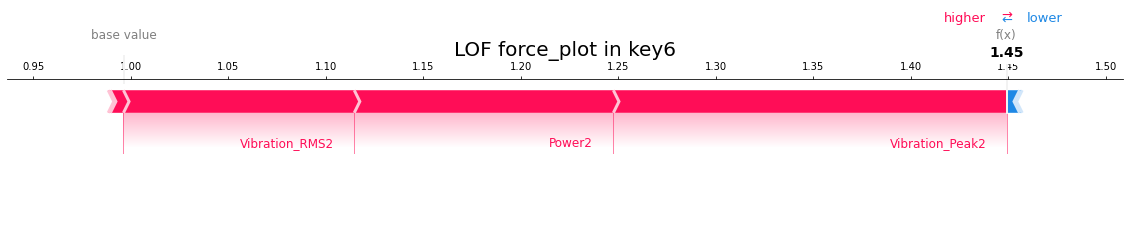

In [51]:
for i in range(1, 7):
  SetData(key_num = i)
  model = LoadModel('LOF',save_path, key_num = i)
  SaveModel(model, best_path, key_num = i)
  DoXAI(model=model, threshold = 1, plot_type = 1)